# Linear regression and Stochastic Gradient Descent

In [17]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.metrics import log_loss, mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [21]:
class SGDRegressor(BaseEstimator):
    def __init__(self, eta=1e-3, n_epochs=3):
        self.eta = eta
        self.n_epochs = n_epochs
        self.mse_ = []
        self.weights_ = []

    def fit(self, X, y):
        X = np.hstack([np.ones([X.shape[0], 1]), X])

        w = np.zeros(X.shape[1])

        for it in tqdm(range(self.n_epochs)):
            for i in range(X.shape[0]):

                new_w = w.copy()
                new_w[0] += self.eta * (y[i] - w.dot(X[i, :]))
                for j in range(1, X.shape[1]):
                    new_w[j] += self.eta * (y[i] - w.dot(X[i, :])) * X[i, j]
                w = new_w.copy()

                self.weights_.append(w)
                self.mse_.append(mean_squared_error(y, X.dot(w)))

        self.w_ = self.weights_[np.argmin(self.mse_)]

        return self

    def predict(self, X):
        X = np.hstack([np.ones([X.shape[0], 1]), X])

        return X.dot(self.w_)

Let’s test out the algorithm on height/weight data. We will predict heights (in inches) based on weights (in lbs).

In [18]:
# for Jupyter-book, we copy data from GitHub, locally, to save Internet traffic,
# you can specify the data/ folder from the root of your cloned
# https://github.com/Yorko/mlcourse.ai repo, to save Internet traffic
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/"

In [19]:
data_demo = pd.read_csv(DATA_PATH + "weights_heights.csv")

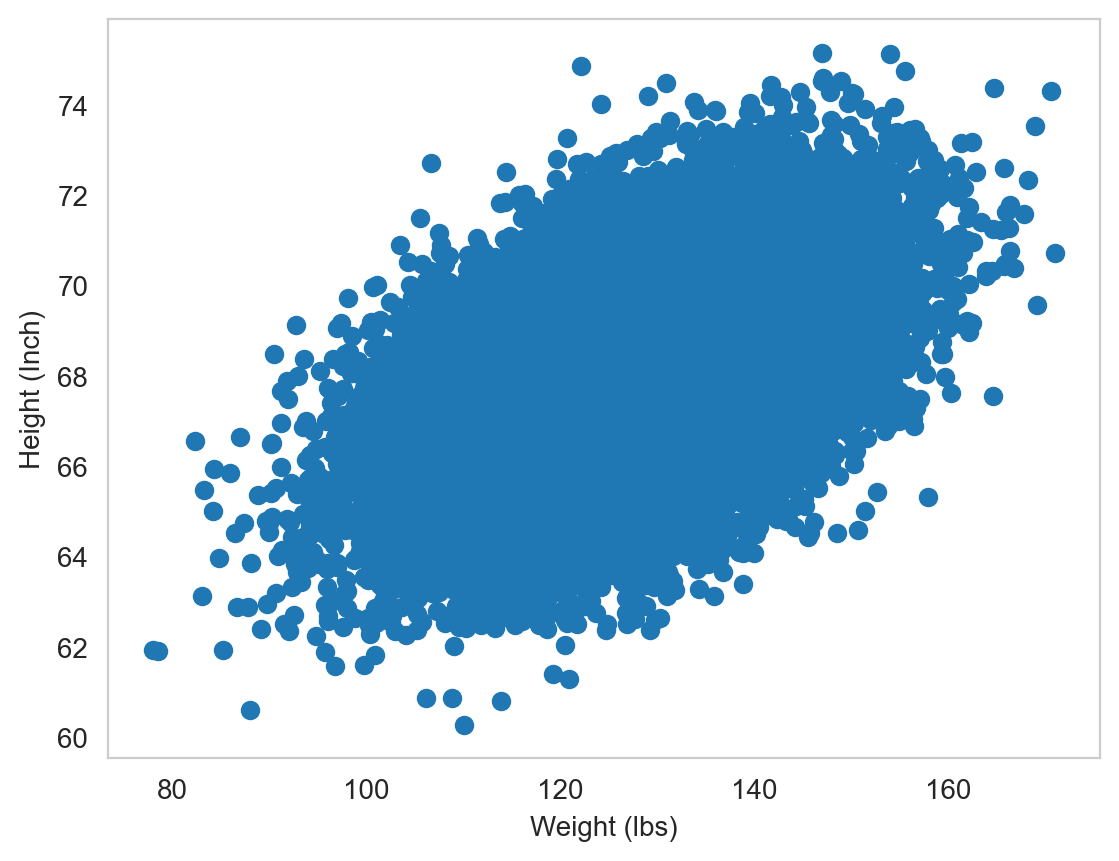

In [20]:
plt.scatter(data_demo["Weight"], data_demo["Height"])
plt.xlabel("Weight (lbs)")
plt.ylabel("Height (Inch)")
plt.grid();

In [14]:
X, y = data_demo["Weight"].values, data_demo["Height"].values

Train/test split and scale data.

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, random_state=17
)

In [23]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape([-1, 1]))
X_valid_scaled = scaler.transform(X_valid.reshape([-1, 1]))

Train created SGDRegressor with (X_train_scaled, y_train) data.

In [24]:
sgd_reg = SGDRegressor()
sgd_reg.fit(X_train_scaled, y_train)

100%|██████████| 3/3 [00:24<00:00,  8.09s/it]


SGDRegressor()

Draw a chart with training process – dependency of mean squared error from the i-th SGD iteration number.

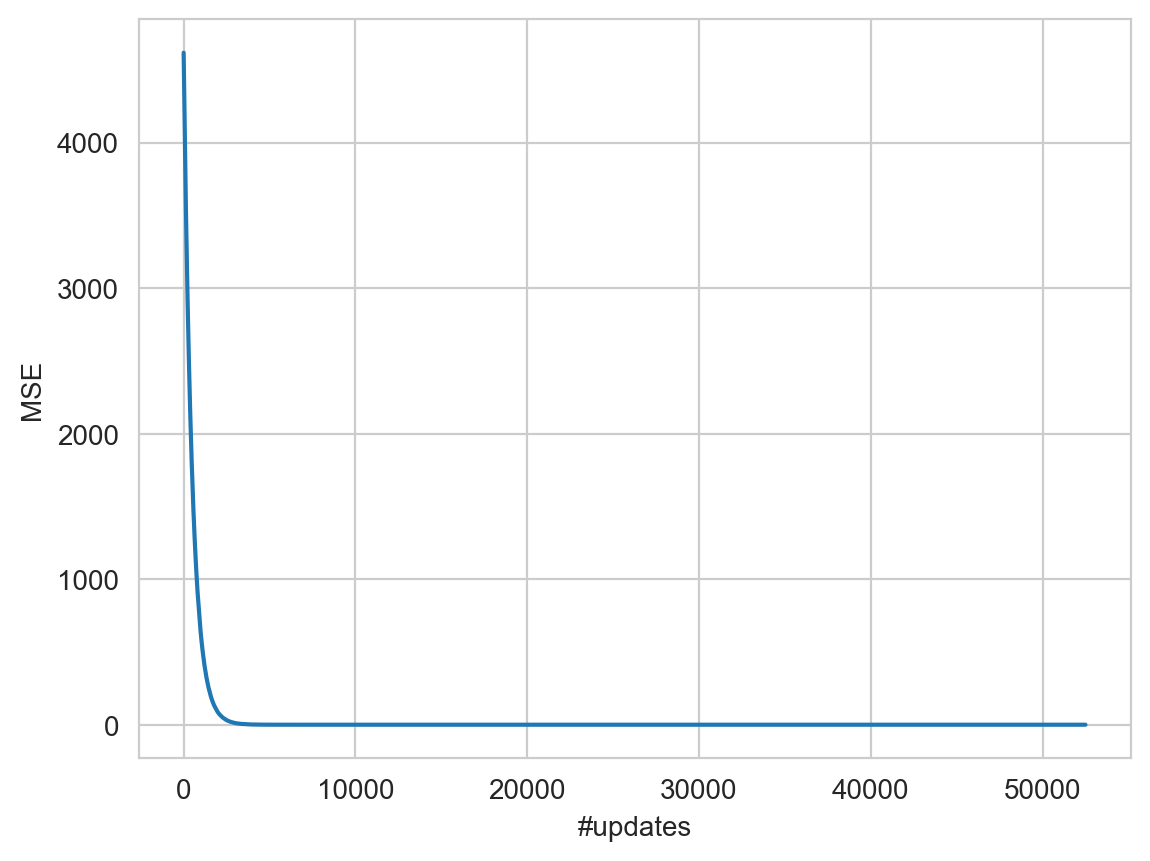

In [25]:
plt.plot(range(len(sgd_reg.mse_)), sgd_reg.mse_)
plt.xlabel("#updates")
plt.ylabel("MSE");

Print the minimal value of mean squared error and the best weights vector.

In [26]:
np.min(sgd_reg.mse_), sgd_reg.w_

(2.7151352406643623, array([67.9898497 ,  0.94447605]))

Draw chart of model weights (W0 and W1) behavior during training.

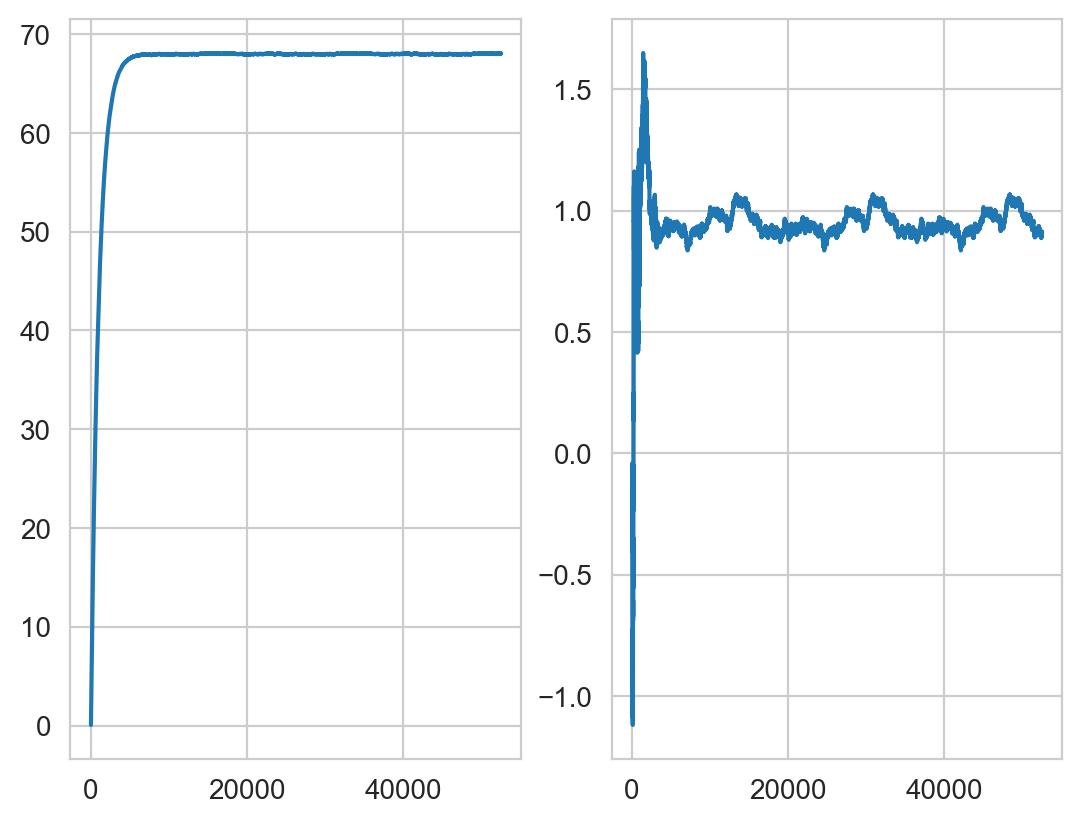

In [27]:
plt.subplot(121)
plt.plot(range(len(sgd_reg.weights_)), [w[0] for w in sgd_reg.weights_])
plt.subplot(122)
plt.plot(range(len(sgd_reg.weights_)), [w[1] for w in sgd_reg.weights_]);

Make a prediction for hold-out set (X_valid_scaled, y_valid) and check MSE value.

In [28]:
sgd_holdout_mse = mean_squared_error(y_valid, sgd_reg.predict(X_valid_scaled))
sgd_holdout_mse

2.6708681207033784

Do the same thing for LinearRegression class from sklearn.linear_model. Evaluate MSE for hold-out set.

In [29]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression().fit(X_train_scaled, y_train)
print(lm.coef_, lm.intercept_)
linreg_holdout_mse = mean_squared_error(y_valid, lm.predict(X_valid_scaled))
linreg_holdout_mse

[0.94537278] 67.98930834742858


2.6708307676676344

In [30]:
try:
    assert (sgd_holdout_mse - linreg_holdout_mse) < 1e-4
    print("Correct!")
except AssertionError:
    print(
        "Something's not good.\n Linreg's holdout MSE: {}"
        "\n SGD's holdout MSE: {}".format(linreg_holdout_mse, sgd_holdout_mse)
    )

Correct!
